# Bloodhound Aure Report
-----------------------------------------
* **Notebook Author:** Marius Elmiger @m8r1us
* **Version:** 0.1

In [1]:
## Import Libraries

In [2]:
from py2neo import Graph
import plotly.graph_objects as go
import altair as alt
alt.renderers.enable('jupyterlab')

RendererRegistry.enable('jupyterlab')

## BloodHound neo4j Database Connection

In [3]:
# Example: Connection string: bolt://localhost:7687 U: neo4j, PW: Bloodhound
g = Graph("bolt://localhost:7687", auth=("neo4j", "Bloodhound"))
g

Graph('bolt://neo4j@localhost:7687')

## Active Directory domain to assess

In [4]:
# Replace with your Active Directory FQDN
domain = "ASSESSMENT.INTRA"
# Replace with your Azure Tenant ID
tenantid = "cdfdd915-c827-4f78-9c4f-7e29bac5d9ed"

In [5]:
domain = domain.upper()
tenantid = tenantid.upper()
domain

'ASSESSMENT.INTRA'

In [6]:
tenantid


'CDFDD915-C827-4F78-9C4F-7E29BAC5D9ED'

## Edge Statistics

In [25]:
query = """
CALL { 
    MATCH  p=(m:User{domain:'""" + domain + """'})-[r:AZResetPassword|AZOwns|AZUserAccessAdministrator|AZContributor|AZAddMembers|AZGlobalAdmin|AZVMContributor|AZOwnsAZAvereContributor]->(n) WHERE m.objectid CONTAINS 'S-1-5-21' RETURN count(p) as AdminToCloudEdges
}
CALL
{
    MATCH (n) WHERE NOT n.objectid='""" + tenantid + """' WITH n MATCH p = shortestPath((n)-[r*1..]->(g:AZTenant {objectid: '""" + tenantid + """'})) RETURN count(p) as TransitiveControlOverYourTenant
}
RETURN *
"""
EdgeStatistics = g.run(query).to_data_frame()
EdgeStatistics

,AdminToCloudEdges,TransitiveControlOverYourTenant
0,11,1283


## Environment Statistic

In [26]:
query = """
CALL { 
    MATCH (a:AZUser) RETURN count(a) as CloudOnlyUsers
}
CALL{
    MATCH (b:Group{domain:'""" + domain + """'}) WHERE b.objectid CONTAINS 'S-1-5' AND b.azsyncid IS NOT NULL RETURN count(b) as SyncedGroups
}
CALL{
    MATCH (c:AZDevice) RETURN count(c) as AzureComputers
}
CALL{
    MATCH (d:AZApp) RETURN count(d) as AzureApps
}
CALL{
    MATCH (e:AZServicePrincipal) RETURN count(e) as AzureServicePrincipals
    }
CALL{
    MATCH (f:AZKeyVault) RETURN count(f) as KeyVaults  
}
CALL{
    MATCH (g:AZSubscription) RETURN count(g) as Subscriptions 
}
CALL{
    MATCH (e:AZResourceGroup) RETURN count(e) as ResourceGroups
}
CALL{
    MATCH (h:AZVM) RETURN count(h) as AzureVMs
}
CALL { 
    MATCH (i:User{domain:'""" + domain + """'}) WHERE i.objectid CONTAINS 'S-1-5' AND i.azname IS NOT NULL RETURN count(i) as SyncedUsers
}
RETURN *
"""
EnvStatistics = g.run(query).to_data_frame()
EnvStatistics

,AzureApps,AzureComputers,AzureServicePrincipals,AzureVMs,CloudOnlyUsers,KeyVaults,ResourceGroups,Subscriptions,SyncedGroups,SyncedUsers
0,5,1,5,5,8,1,4,1,51,229


## Quality Assurance

### Hybrid paths to Global Admin

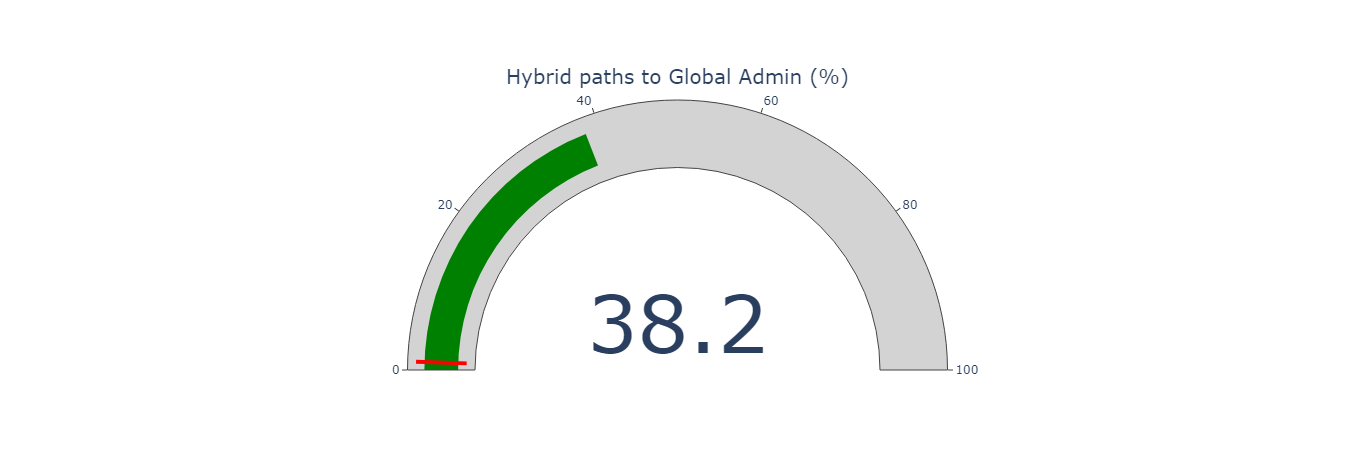

In [23]:
query = """
   MATCH (totalUsers:User)
        WITH COUNT(totalUsers) as userCount
        MATCH p =shortestPath((UsersWithPath:User)-[:MemberOf|HasSession|AdminTo|AllExtendedRights|AddMember|ForceChangePassword|GenericAll|GenericWrite|Owns|WriteDacl|WriteOwner|CanRDP|ExecuteDCOM|AllowedToDelegate|ReadLAPSPassword|Contains|GpLink|AddAllowedToAct|AllowedToAct|SQLAdmin|ReadGMSAPassword|HasSIDHistory|CanPSRemote|AZAddMembers|AZContains|AZContributor|AZGetCertificates|AZGetKeys|AZGetSecrets|AZGlobalAdmin|AZOwns|AZPrivilegedRoleAdmin|AZResetPassword|AZUserAccessAdministrator|AZAppAdmin|AZCloudAppAdmin|AZRunsAs|AZKeyVaultContributor*1..]->(m:AZTenant {objectid:'""" + tenantid + """'}))
        RETURN 100.0 * COUNT(DISTINCT UsersWithPath) / userCount as PercentUsersToGa
"""
PercentUsersToGaCount = g.run(query).to_data_frame()

# Extract variable
value_PercentUsersToGaCount = PercentUsersToGaCount['PercentUsersToGa'].values[0]

# Create Graphic
fig = go.Figure(go.Indicator(
    domain = {'x': [0, 1], 'y': [0, 1]},
    value = (value_PercentUsersToGaCount),
    mode = "gauge+number",
    title = {'text': "Hybrid paths to Global Admin (%)"},
    gauge = {'axis': {'range': [None, 100]},
             'steps' : [{'range': [0, 250], 'color': "lightgray"}],
             'threshold' : {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': 1}}))
fig.show()

## Top 10 Users with  Admin Rights to Azure VM's

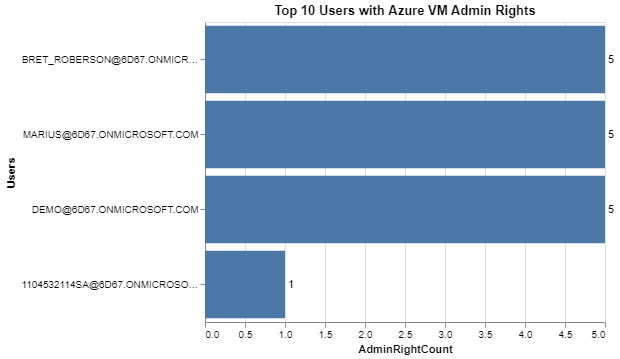

In [12]:
query = """
Match (n) where n:User OR n:AZUser
Optional MATCH (n)-[:AZContributor]->(c1:AZVM)
WITH n, COLLECT(c1) AS tempVar
UNWIND tempVar AS computers
RETURN n.azname AS Users,COUNT(DISTINCT(computers)) AS AdminRightCount
ORDER BY AdminRightCount DESC limit 10
"""
GroupsWithLocalAdminRights = g.run(query).to_data_frame()

bars = alt.Chart(GroupsWithLocalAdminRights, title="Top 10 Users with Azure VM Admin Rights").mark_bar().encode(
    x='AdminRightCount:Q',
    y=alt.Y(
        "Users:N",
        sort=alt.EncodingSortField(
            field="AdminRightCount",
            order="descending"
        )
    )
)
text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3
).encode(
    text='AdminRightCount:Q'
)
(bars + text).properties(height=300)

## Top 10 Users with Resource Group Admin Rights

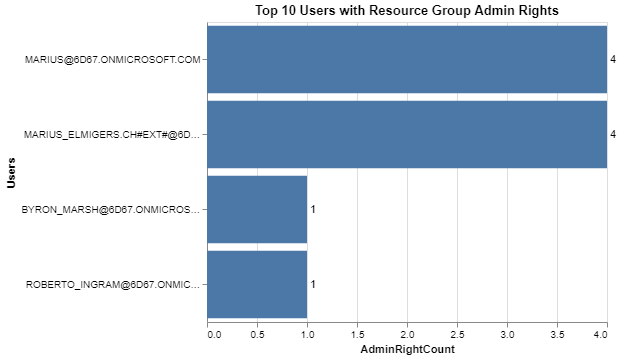

In [21]:
query = """
Match (n) where n:User OR n:AZUser
Optional MATCH (n)-[]->(c1:AZResourceGroup)
WITH n, COLLECT(c1) AS tempVar
UNWIND tempVar AS computers
RETURN n.azname AS Users,COUNT(DISTINCT(computers)) AS AdminRightCount
ORDER BY AdminRightCount DESC limit 10
"""
GroupsWithLocalAdminRights = g.run(query).to_data_frame()

bars = alt.Chart(GroupsWithLocalAdminRights, title="Top 10 Users with Resource Group Admin Rights").mark_bar().encode(
    x='AdminRightCount:Q',
    y=alt.Y(
        "Users:N",
        sort=alt.EncodingSortField(
            field="AdminRightCount",
            order="descending"
        )
    )
)
text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3
).encode(
    text='AdminRightCount:Q'
)
(bars + text).properties(height=300)